<a href="https://colab.research.google.com/github/GeorgeWilliam1999/XAI-Project/blob/main/Quantum_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##NEXT STEP
(to be updated every session)

Literature review

Summarise IRIS and penguin dataset finding in latex

Create lime using binary Quantum classifier

Finish class function

Improve the accuracy of the classifier:

1.   Try alternative Cost functions - Cross entrophy?






  



In [1]:
import qulacs
import numpy as np
from qulacs import QuantumState
from qulacs.gate import X, RY, RZ, DenseMatrix
from sklearn.datasets import load_iris
import seaborn as sns
import pandas as pd 
from matplotlib import pyplot as plt
import time
import random
import csv
import itertools
import json
import re

import numpy as np
import pennylane as qml
from concurrent.futures import ThreadPoolExecutor

from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Classical LIME
from lime.lime_text import LimeTextExplainer

# OOP

# QML
## Parameterised quantum circuit set up

Starting goal circuit:
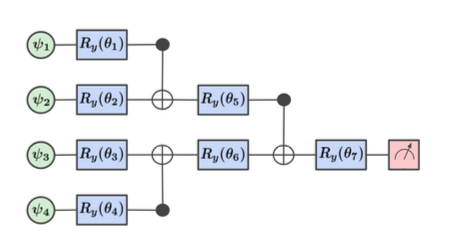

This circuit is able to perform binary classification of data. The anzats is convolutional which helps avoid the barren plat. which can prevent the variational circuit from being optermised

## Penguin data processing

## Iris data processing

In [2]:
#Load and view iris data set
iris = load_iris()
iris.DESCR

'.. _iris_dataset:\n\nIris plants dataset\n--------------------\n\n**Data Set Characteristics:**\n\n:Number of Instances: 150 (50 in each of three classes)\n:Number of Attributes: 4 numeric, predictive attributes and the class\n:Attribute Information:\n    - sepal length in cm\n    - sepal width in cm\n    - petal length in cm\n    - petal width in cm\n    - class:\n            - Iris-Setosa\n            - Iris-Versicolour\n            - Iris-Virginica\n\n:Summary Statistics:\n\n============== ==== ==== ======= ===== ====================\n                Min  Max   Mean    SD   Class Correlation\n============== ==== ==== ======= ===== ====================\nsepal length:   4.3  7.9   5.84   0.83    0.7826\nsepal width:    2.0  4.4   3.05   0.43   -0.4194\npetal length:   1.0  6.9   3.76   1.76    0.9490  (high!)\npetal width:    0.1  2.5   1.20   0.76    0.9565  (high!)\n============== ==== ==== ======= ===== ====================\n\n:Missing Attribute Values: None\n:Class Distribution: 

In [3]:
iris.data.shape,iris.target.shape

((150, 4), (150,))

In [4]:
#Load iris data and classification to the same array.
features = iris.feature_names
features.append('label')
data = np.zeros((150,5))
data[:,0:4] = iris.data
data[:,4] = iris.target


In [5]:
iris_df = pd.DataFrame(data = data, columns = features)


In [6]:
iris_df.head(100)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
95,5.7,3.0,4.2,1.2,1.0
96,5.7,2.9,4.2,1.3,1.0
97,6.2,2.9,4.3,1.3,1.0
98,5.1,2.5,3.0,1.1,1.0


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.33, random_state=42)

train_data = np.zeros((X_train.shape[0], X_train.shape[1] + 1))
train_data[:,0:4] = X_train
train_data[:,4] = y_train
train_df = pd.DataFrame(data = train_data, columns = features)

test_data = np.zeros((X_test.shape[0], X_test.shape[1] + 1))
test_data[:,0:4] = X_test
test_data[:,4] = y_test
test_df = pd.DataFrame(data = test_data, columns = features)



Featurewise pair plots:

## Data preprocessing, embedding and computational circuit

The data array has the form (x,y), where x is the feature vector and y is tge label. The feature vector has 4 element and the labels are 0,1,2 respectivly. To use a parameterised quantum circuit each data vector x must be transformed to a tensor product of qubits.

Encoding this data into qubits can be done in a number of ways. To begin with I will repeat the work done by Dominic, and use the qubit embedding $x_n^d \mapsto \bigotimes_{n=1}^4 cos(x_n^d) |0> + sin(x_n^d) |1>$ where $x_n^d$ is the nth feature of the dth sample. Note that this embedded state is the tensor product of 4 qubits, which gives a state vector of size $2^4 = 16$. Note also that for the qubit embedding we require all the x values be in the range $[0,\frac{\pi}{2})$.

To encode the data I will initialise 4 cubits in the $|0>$ computational basis state and operate on each them with the gate $U(X_n^d) := e^{-ix_n^d\sigma_y}$. This process will encode a single data points.

But first, the data will need normalising as described above.

### Preprocessing

Test train split:

In [8]:
#This function takes a data set and returns a qubit embedding of the data.
#Normalise from the bottom
def half_pi_norm(data):
  #Normalise data
  dim = data.shape[1]
  min_values = np.zeros(dim)

  for i in range(dim):
    min_values[i] = np.amin(data[:,i])
    data[:,i] = data[:,i] - min_values[i]

  largest_values = np.zeros(dim)
  
  for i in range(dim):
    largest_values[i] = np.amax(data[:,i])


  #Normalise classical data
  normalised_data = np.zeros((data.shape[0],dim))

  for i in range(dim):

    normalised_data[:,i] = data[:,i]*(np.pi/(2*largest_values[i]))

  return normalised_data

Rescaled to be between 0 and pi/2 using pandas dataframe functions

In [ ]:
train_df[train_df.columns[:4]] -= train_df[train_df.columns[:4]].min()
train_df[train_df.columns[:4]] /= train_df[train_df.columns[:4]].max()

train_df[train_df.columns[:4]] *= np.pi/2 #Change this line to normalize it to 1. If you want, cahnge back to np.pi/2
train_df[train_df.columns[:4]].head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0.646798,0.642598,0.869548,0.785398
1,1.524596,0.713998,1.542746,1.308997
2,0.600599,0.713998,0.953698,0.916298
3,0.369599,1.070997,0.084150,0.065450
4,1.570796,0.571199,1.570796,1.243547


In [ ]:
test_df[test_df.columns[:4]] -= test_df[test_df.columns[:4]].min()
test_df[test_df.columns[:4]] /= test_df[test_df.columns[:4]].max()
test_df[test_df.columns[:4]] *= np.pi/2 #Change this line to normalize it to 1. If you want, cahnge back to np.pi/2
test_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,0.762958,0.428399,0.985076,0.719948,1.0
1,0.583439,1.142397,0.186366,0.130900,0.0
2,1.481037,0.285599,1.570796,1.439897,2.0
3,0.718078,0.499799,0.931828,0.916298,1.0
4,1.077117,0.428399,1.011699,0.850848,1.0


In [11]:
#normed_train_data = half_pi_norm(X_train)
#normed_test_data = half_pi_norm(X_test)

### Embedding circuit (Qubit Embedding)

Now I create the embedding circuit as a function that acts on a point and returns a quantum state.

In [12]:
#Function to perform pointwise qubit embedding.
def pointwise_qubit_embedding(point):
  n = len(point)
  state = QuantumState(n)
  state.set_zero_state()
  for i in range(n):
    ry_gate = RY(i, point[i])
    ry_gate.update_quantum_state(state)

  return state

### Computational Circuit 

To build two qubit gates one needs to use combinations of single qubit gates and control operations.

I am copy the state after each operation for comparison.

Now its time for a parameterised quantum circuit.

Each two qubit unitary will be specified by two angles

In [13]:
from qulacs import ParametricQuantumCircuit
from qulacs import QuantumState
import numpy as np
#Circuit 6 Hur et al
def U_conv_6():
  #Metadata
  n = 4
  depth = 3
  angle = 0
  # construct parametric quantum circuit with random rotation
  circuit = ParametricQuantumCircuit(n)

  target_layer_1 = np.array([0,1,2,3], dtype = 'int')
  for i in target_layer_1:
    circuit.add_parametric_RY_gate(target_layer_1[i],angle)
  circuit.add_CNOT_gate(0,1)
  circuit.add_CNOT_gate(2,3)
  for i in target_layer_1:
    circuit.add_parametric_RY_gate(target_layer_1[i],angle)
  circuit.add_CNOT_gate(0,1)
  circuit.add_CNOT_gate(2,3)
  for i in target_layer_1:
    circuit.add_parametric_RY_gate(target_layer_1[i],angle)  
  circuit.add_CNOT_gate(1,2)

  target_layer_2 = [1,2]
  for i in range(len(target_layer_2)):
    circuit.add_parametric_RY_gate(target_layer_2[i],angle)
  circuit.add_CNOT_gate(1,2)
  for i in range(len(target_layer_2)):
    circuit.add_parametric_RY_gate(target_layer_2[i],angle)
  circuit.add_CNOT_gate(1,2)

  circuit.add_parametric_RY_gate(2,angle)

  return circuit

In [14]:
circuit = U_conv_6()
circuit.get_parameter_count

<bound method PyCapsule.get_parameter_count of <qulacs_core.ParametricQuantumCircuit object at 0x00000156C12B5FB0>>

In [15]:
from qulacs import ParametricQuantumCircuit
from qulacs import QuantumState
import numpy as np
def U_dom():
  #Metadata
  n = 4
  depth = 3
  
  angle = 0
  # construct parametric quantum circuit with random rotation
  circuit = ParametricQuantumCircuit(n)

  target_layer_1 = np.array([0,1,2,3], dtype = 'int')
  for i in target_layer_1:
    circuit.add_parametric_RY_gate(target_layer_1[i],angle)
  circuit.add_CNOT_gate(0,1)
  circuit.add_CNOT_gate(3,2)

  target_layer_2 = [1,2]
  for i in range(len(target_layer_2)):
    circuit.add_parametric_RZ_gate(target_layer_2[i],angle)
  circuit.add_CNOT_gate(1,2)

  circuit.add_parametric_RY_gate(2,angle)

  return circuit

## Get expectation

The below function will return the expectation scaled between 2 and 0.

In [16]:
def get_expectation(x, U, theta):
  #define PQC
  circuit =  U()
  for i in range(circuit.get_parameter_count()):
    circuit.set_parameter(i,theta[i])

  #Define and embed data point, x is an element of the normalised data set
  point = x
  state = pointwise_qubit_embedding(point)
  circuit.update_quantum_state(state)
  obs = Observable(4)
  obs.add_operator(1.,'Z 1')
  exp = obs.get_expectation_value(state)

  return exp + 1

# Trinary Clasification

In [17]:
from qulacs import Observable

## prepare circuit data

In [18]:
circuit = U_conv_6()
theta_0 = np.random.rand(17)
for i in range(circuit.get_parameter_count()):
  circuit.set_parameter(i,theta_0[i])

In [19]:
circuit.get_parameter

<bound method PyCapsule.get_parameter of <qulacs_core.ParametricQuantumCircuit object at 0x00000156C12980F0>>

In [20]:
parameter_count = circuit.get_parameter_count()
param = [circuit.get_parameter(ind) for ind in range(parameter_count)]

In [21]:
param

[0.920471606769926,
 0.47307887635728696,
 0.4886368389568637,
 0.7944223091998694,
 0.7815281571943756,
 0.7430752503661716,
 0.2896814188305028,
 0.4287709566714004,
 0.08005341944743671,
 0.9407194883549286,
 0.9047289546522153,
 0.23697443868277623,
 0.28150298849037414,
 0.008974197921031934,
 0.6564832150586016,
 0.18202467605686257,
 0.06788865060708793]

NOTE TO SELF

use pca on the components to see what the most important eigen vlaues/vectors are doing.

In [22]:
train_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,0.646798,0.642598,0.869548,0.785398,1.0
1,1.524596,0.713998,1.542746,1.308997,2.0
2,0.600599,0.713998,0.953698,0.916298,1.0
3,0.369599,1.070997,0.084150,0.065450,0.0
4,1.570796,0.571199,1.570796,1.243547,2.0


## Define operators and make initial predictions
Initatial expectation and classification is prior to training.

I will use the Pauli Z operator to take the expectation of the unitary evolution of embedded data points.

In [23]:
from qulacs import PauliOperator
p_s = 'Z 1'
z = PauliOperator(p_s,1)

In [24]:
#Classify and expectation value that is reshaped to be between 0 and 2.
def classify_tri(exp):
  if exp >= 1.33:
    pred = 2
  elif exp < 1.33 and exp > 0.66:
    pred = 1
  else:
    pred = 0
  return pred

Below I visualise the naive predictions on the training data. Clearly the predictions are sub optimal.

In [25]:
expectation = []
for i in range(len(train_df)):
  expectation.append(get_expectation(train_df.iloc[i][0:4],U_conv_6,np.random.rand(17)))
train_df.insert(4,'Expectation', expectation)


C:\Users\migue\AppData\Local\Temp\ipykernel_9028\1344291649.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ry_gate = RY(i, point[i])


Naive expectation values with random angle, very poor but thats expected.

In [26]:
def cost_train(theta):
  #get predictions
  expect = np.zeros(len(train_df))
  for i in range(len(train_df)):
    expect[i] = get_expectation(train_df.iloc[i][0:4],U_conv_6, theta)
  #Simple MSE example
  
  #Sxpectation values
  L = ((expect - y_train)**2).mean()
  cost_values.append(L)
  return L

In [27]:
theta = np.random.rand(17)

In [28]:
train_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Expectation,label
0,0.646798,0.642598,0.869548,0.785398,0.844940,1.0
1,1.524596,0.713998,1.542746,1.308997,0.339592,2.0
2,0.600599,0.713998,0.953698,0.916298,0.111075,1.0
3,0.369599,1.070997,0.084150,0.065450,0.235254,0.0
4,1.570796,0.571199,1.570796,1.243547,0.965909,2.0


In [29]:
#find number of correct predictions
correct = 0
for i in range(len(y_train)):
  if y_train[i] == classify_tri(train_df['Expectation'][i]):
    correct += 1

print('The initial calssification is',(correct/len(y_train)) * 100, '% accurate')


The initial calssification is 40.0 % accurate


## Optimise
The updated parameters are generated and tested below:

In [30]:
from scipy.optimize import minimize #BFGS works well/cobyla

In [31]:
#%%time
#Use scipy minimised to find the vector theta that minimised the cost function.
cost_values = []
theta_0 = np.random.rand(17)
result = minimize(cost_train, theta_0, method='cobyla')

theta = result.x


C:\Users\migue\AppData\Local\Temp\ipykernel_9028\1344291649.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ry_gate = RY(i, point[i])


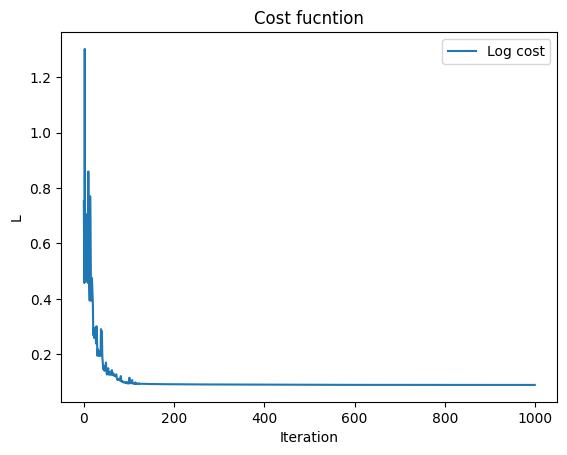

In [32]:
plt.plot(np.linspace(0,len(cost_values)-1,len(cost_values)-1).round(),(cost_values[:-1]),label = 'Log cost')
#Plot the difference between the exact and trial function
plt.ylabel('L')
plt.xlabel('Iteration')
plt.title('Cost fucntion')
plt.legend(loc="best")
plt.show()

## Reclasify

In [33]:
def cost_test(theta):
  #get predictions
  expect = np.zeros(len(test_df))
  for i in range(len(test_df)):
    expect[i] = get_expectation(test_df.iloc[i][0:4],U_conv_6,theta)
  #Simple MSE example
  L = ((expect - y_test)**2).mean()

  return L

In [34]:
cost_test(theta),cost_test(theta_0)

C:\Users\migue\AppData\Local\Temp\ipykernel_9028\1344291649.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ry_gate = RY(i, point[i])


(np.float64(0.09061414161018401), np.float64(0.6190556629189625))

In [35]:
better_predictions = np.zeros(len(test_df))
expectations = np.zeros(len(test_df))
for i in range(len(test_df)):
  better_predictions[i] = classify_tri(get_expectation(test_df.iloc[i][0:4],U_conv_6, theta))
  expectations[i] = get_expectation(test_df.iloc[i][0:4],U_conv_6, theta)

test_df.insert(4,'Expectation Values', expectations)
test_df.insert(5,'Quantum Prediction', better_predictions)

C:\Users\migue\AppData\Local\Temp\ipykernel_9028\1344291649.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ry_gate = RY(i, point[i])


In [36]:
correct = 0
for i in range(len(test_df)):
  if test_df.iloc[i][5] == test_df.iloc[i][6]:
    correct += 1 

print('The final calssification is',(correct/len(test_df)) * 100, '% accurate.')

The final calssification is 100.0 % accurate.


C:\Users\migue\AppData\Local\Temp\ipykernel_9028\1957188846.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if test_df.iloc[i][5] == test_df.iloc[i][6]:


## Prediction graphs (deleted them)

Generate shadded boundary values by generating and fitting a model

## Feature space landscape and local Interpretability of solution

Stop using pandas, its shit.

CPU/GPU kernel for classification

In [37]:
import numba
from numba import jit, njit

In [38]:
N = 30
w = np.linspace(0,np.pi/2,N, endpoint = True)
x = np.linspace(0,np.pi/2,N, endpoint = True)
y = np.linspace(0,np.pi/2,N, endpoint = True)
z = np.linspace(0,np.pi/2,N, endpoint = True)

ww, xx, yy, zz = np.meshgrid(w,x,y,z)

w_flat = ww.reshape(N**4)
x_flat = xx.reshape(N**4)
y_flat = yy.reshape(N**4)
z_flat = zz.reshape(N**4)
fs = np.array([w_flat,x_flat, y_flat, z_flat]).reshape(N**4,4)

feature_space = pd.DataFrame([w_flat,x_flat, y_flat, z_flat]).T
feature_space.columns = features[0:4]

In [39]:
feature_space

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.054165
2,0.000000,0.000000,0.000000,0.108331
3,0.000000,0.000000,0.000000,0.162496
4,0.000000,0.000000,0.000000,0.216662
...,...,...,...,...
809995,1.570796,1.570796,1.570796,1.354135
809996,1.570796,1.570796,1.570796,1.408300
809997,1.570796,1.570796,1.570796,1.462466
809998,1.570796,1.570796,1.570796,1.516631


Make predictions on the feature space mesh grid

In [40]:
#feature_space = feature_space[feature_space['Quantum Prediction'] != 2]

# Binary Classification 

## Convert and visualise data

The embedding and computational circuits will be unchanged.

In [41]:
#Copy data and alter labels for binar classification.
y_test_bi = y_test
y_train_bi = y_train

X_test_bi = X_test
X_train_bi = X_train

for i in range(len(X_test_bi)):
  if y_test_bi[i] == 2:
    y_test_bi[i] = 1

for i in range(len(y_train)):
  if y_train_bi[i] == 2:
    y_train_bi[i] = 1


In [42]:
X_test_bi[1]

array([5.7, 3.8, 1.7, 0.3])

In [43]:
normed_train_data_bi = half_pi_norm(X_train_bi)
normed_test_data_bi = half_pi_norm(X_test_bi)

In [44]:
X_train_bi, X_test_bi, y_train_bi, y_test_bi = train_test_split(iris.data, iris.target, test_size=0.33, random_state=42)

for i in range(len(y_test_bi)):
  if y_test_bi[i] == 2:
    y_test_bi[i] = 1

for i in range(len(y_train_bi)):
  if y_train_bi[i] == 2:
    y_train_bi[i] = 1

train_data_bi = np.zeros((X_train_bi.shape[0], X_train_bi.shape[1] + 1))
train_data_bi[:,0:4] = X_train_bi
train_data_bi[:,4] = y_train_bi
train_df_bi = pd.DataFrame(data = train_data_bi, columns = features)

test_data_bi = np.zeros((X_test_bi.shape[0], X_test_bi.shape[1] + 1))
test_data_bi[:,0:4] = X_test_bi
test_data_bi[:,4] = y_test_bi
test_df_bi = pd.DataFrame(data = test_data_bi, columns = features)

In [45]:
train_df_bi[train_df_bi.columns[:4]] -= train_df_bi[train_df_bi.columns[:4]].min()
train_df_bi[train_df_bi.columns[:4]] /= train_df_bi[train_df_bi.columns[:4]].max()
train_df_bi[train_df_bi.columns[:4]] *= np.pi/2

In [46]:
test_df_bi[test_df_bi.columns[:4]] -= test_df_bi[test_df_bi.columns[:4]].min()
test_df_bi[test_df_bi.columns[:4]] /= test_df_bi[test_df_bi.columns[:4]].max()
test_df_bi[test_df_bi.columns[:4]] *= np.pi/2

In [47]:
a = np.random.rand(5)

a[[1,4,2]]

array([0.98796086, 0.33400928, 0.08187419])

In [48]:
y_train, y_test, expectations

(array([1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1]),
 array([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 1]),
 array([1.18777198, 0.26444328, 1.80910853, 1.27866688, 1.28807894,
        0.29309471, 1.0418527 , 1.68042534, 1.26009736, 1.06281768,
        1.56423915, 0.27249402, 0.20656742, 0.26046033, 0.24414424,
        1.32378553, 1.72577505, 1.03774247, 1.19597807, 1.69500369,
        0.27398732, 1.46629731, 0.30327772, 1.66456789, 1.60731959,
        1.69289916, 1.5594524 , 1.75774783, 0.32064198, 0.29342518,
        0.17364451, 0.33355564, 1.20296251, 0.2461403 , 0.2412878 ,
      

In [49]:
def get_expectation_bi(x, U, theta):
  #define PQC
  circuit =  U()
  for i in range(circuit.get_parameter_count()):
    circuit.set_parameter(i,theta[i])

  #Define and embed data point, x is an element of the normalised data set
  point = x
  state = pointwise_qubit_embedding(point)
  circuit.update_quantum_state(state)
  obs = Observable(4)
  obs.add_operator(1.,'Z 1')
  exp = obs.get_expectation_value(state)
  #print(exp)
  exp = (exp + 1)/2
  

  return exp

In [50]:
#Binary cost function:
def bi_cost_train(theta):
  #get expectations
  expectations = np.zeros(len(train_df_bi))
  for i in range(len(train_df_bi)):
    expectations[i] = get_expectation_bi(train_df_bi.iloc[i][0:4],U_conv_6, theta)
  #Simple MSE example
  
  #predictions are currently expectation values
  L = ((expectations - y_train)**2).mean()
  #print(L)
  #print(expectations)
  return L

In [51]:
#Define the binary VQC and set initial values of theta
bi_circuit = U_conv_6()
theta_0 = np.random.rand(17)
for i in range(bi_circuit.get_parameter_count()):
  bi_circuit.set_parameter(i,theta_0[i])

parameter_count = bi_circuit.get_parameter_count()
param = [bi_circuit.get_parameter(ind) for ind in range(parameter_count)]
param

[0.1810549540561356,
 0.17515323349343326,
 0.16703056026435603,
 0.43232074569916434,
 0.4380707907065772,
 0.6364841779086833,
 0.514492060205193,
 0.8792596775736016,
 0.362935923182801,
 0.9719861907156909,
 0.5748622361721826,
 0.36844978692504937,
 0.25113813030992915,
 0.06932165936464219,
 0.855602794355804,
 0.8056233983396471,
 0.8253263158411249]

In [52]:
#Define the pauli matrix for which the expectation will be taken.
from qulacs import PauliOperator
p_s = 'Z 1'
z = PauliOperator(p_s,1)

In [53]:
x = train_df_bi.iloc[0][0:4]
xp = get_expectation_bi(x,U_dom,theta)

C:\Users\migue\AppData\Local\Temp\ipykernel_9028\1344291649.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ry_gate = RY(i, point[i])


In [54]:
#Classify and expectation value that is reshaped to be between 0 and 1.
def classify_bi(exp):
  if exp >= 0.5:
    pred = 1
  else:
    pred = 0
  return pred

In [55]:
bi_expectation = []
for i in range(len(train_df_bi)):
  bi_expectation.append(get_expectation_bi(train_df_bi.iloc[i][0:4],U_conv_6,np.random.rand(17)))
train_df_bi.insert(4,'Test Binary Expectation', bi_expectation)

C:\Users\migue\AppData\Local\Temp\ipykernel_9028\1344291649.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ry_gate = RY(i, point[i])


In [56]:
#find number of correct predictions
correct = 0
for i in range(len(train_df_bi)):
  if train_df_bi['label'][i] == classify_bi(train_df_bi['Test Binary Expectation'][i]):
    correct += 1

print('The initial calssification is',(correct/len(y_train)) * 100, '% accurate')

The initial calssification is 47.0 % accurate


In [57]:
train_df_bi['Binary Expectation'] = bi_expectation

In [58]:
train_df_bi

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Test Binary Expectation,label,Binary Expectation
0,0.646798,0.642598,0.869548,0.785398,0.540093,1.0,0.540093
1,1.524596,0.713998,1.542746,1.308997,0.476072,1.0,0.476072
2,0.600599,0.713998,0.953698,0.916298,0.341706,1.0,0.341706
3,0.369599,1.070997,0.084150,0.065450,0.085364,0.0,0.085364
4,1.570796,0.571199,1.570796,1.243547,0.565184,1.0,0.565184
...,...,...,...,...,...,...,...
95,0.831598,0.571199,0.813448,0.785398,0.396183,1.0,0.396183
96,0.277199,0.356999,0.953698,1.047198,0.604772,1.0,0.604772
97,0.692998,1.427997,0.028050,0.065450,0.371524,0.0,0.371524
98,0.692998,0.428399,0.813448,0.719948,0.496944,1.0,0.496944


## Optimise

In [59]:
#%%time
#Use scipy minimised to find the vector theta that minimised the cost function.
theta_0 = np.random.rand(17)
result = minimize(cost_train, theta_0, method='cobyla')
theta = result.x

C:\Users\migue\AppData\Local\Temp\ipykernel_9028\1344291649.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ry_gate = RY(i, point[i])


In [60]:
def bi_cost_test(theta):
  #get predictions
  predictions_bi = np.zeros(len(test_df_bi))
  for i in range(len(test_df_bi)):
    predictions_bi[i] = get_expectation_bi(test_df_bi.iloc[i][0:4],U_conv_6,theta)
  #Simple MSE example
  L = ((predictions_bi - y_test)**2).mean()
  return L

In [61]:
theta, theta_0

(array([ 2.10378374,  1.00641109,  0.49259226, -0.47524077,  0.50007341,
         0.27950743,  2.28839915,  2.37677772,  0.68316272,  0.18525253,
         0.32621573,  1.00492269,  0.80414056,  0.92578564,  0.48445473,
         0.59041797,  0.4497299 ]),
 array([0.37103316, 0.64964056, 0.66016573, 0.65225359, 0.85803576,
        0.17481599, 0.89104811, 0.74448452, 0.63188676, 0.18347161,
        0.50043488, 0.21475063, 0.09738606, 0.87053484, 0.70312971,
        0.82760616, 0.00393329]))

In [62]:
bi_cost_test(theta),bi_cost_test(theta_0)

C:\Users\migue\AppData\Local\Temp\ipykernel_9028\1344291649.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ry_gate = RY(i, point[i])


(np.float64(0.14752217047408417), np.float64(0.30829976286857275))

In [63]:
bi_better_predictions = np.zeros(len(test_df_bi))
expectation_bi = np.zeros(len(test_df_bi))
for i in range(len(test_df_bi)):
  bi_better_predictions[i] = classify_bi(get_expectation_bi(test_df_bi.iloc[i][0:4],U_conv_6, theta))
  expectation_bi[i] = get_expectation_bi(test_df_bi.iloc[i][0:4],U_conv_6, theta)

test_df_bi.insert(4,'Expectation Values', expectation_bi)
test_df_bi.insert(5,'Quantum Prediction', bi_better_predictions)

C:\Users\migue\AppData\Local\Temp\ipykernel_9028\1344291649.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ry_gate = RY(i, point[i])


In [64]:
test_df_bi.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Expectation Values,Quantum Prediction,label
0,0.762958,0.428399,0.985076,0.719948,0.470573,0.0,1.0
1,0.583439,1.142397,0.186366,0.130900,0.071209,0.0,0.0
2,1.481037,0.285599,1.570796,1.439897,0.686719,1.0,1.0
3,0.718078,0.499799,0.931828,0.916298,0.484305,0.0,1.0
4,1.077117,0.428399,1.011699,0.850848,0.516972,1.0,1.0


In [65]:
correct = 0
for i in range(len(test_df_bi)):
  if test_df_bi.iloc[i][5] == test_df_bi.iloc[i][6]:
    correct += 1 

print('The final classification is',(correct/len(test_df_bi)) * 100, '% accurate on the test data')

C:\Users\migue\AppData\Local\Temp\ipykernel_9028\1988863878.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if test_df_bi.iloc[i][5] == test_df_bi.iloc[i][6]:


The final classification is 72.0 % accurate on the test data


<Axes: xlabel='sepal length (cm)', ylabel='sepal width (cm)'>

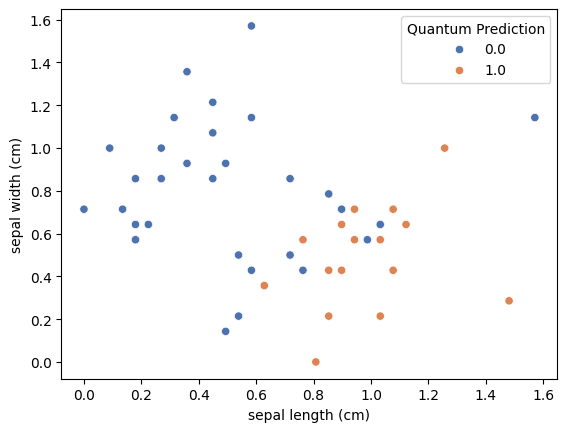

In [66]:
sns.scatterplot(data=test_df_bi, x=test_df_bi.iloc[:,0], y=test_df_bi.iloc[:,1], hue="Quantum Prediction", palette="deep")

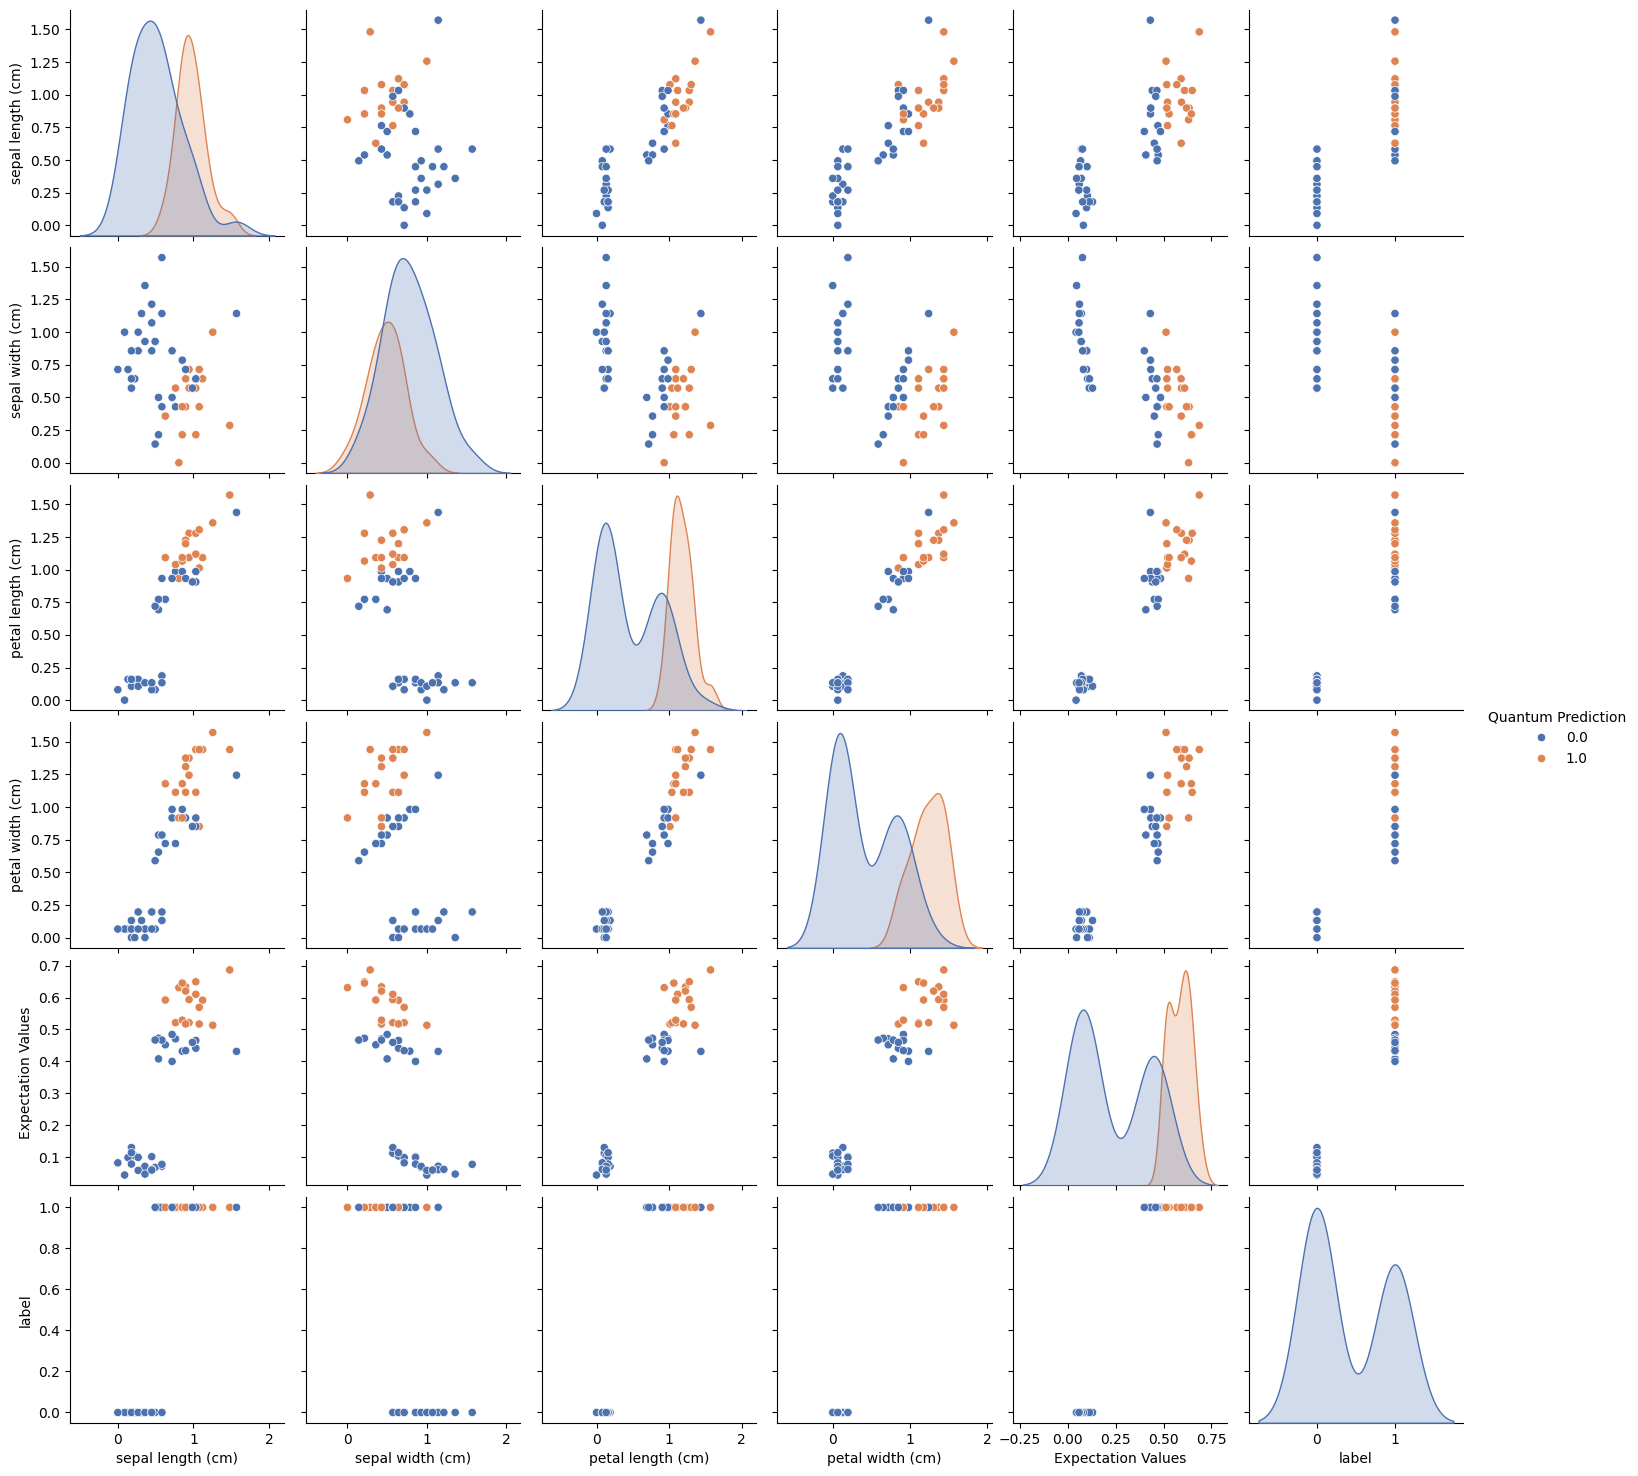

In [67]:
sns.pairplot(test_df_bi, hue="Quantum Prediction", palette = 'deep')

## Feature space landscape and local interpretability of solution

In [ ]:
N = 30
w = np.linspace(0,np.pi/2,N, endpoint = True)
x = np.linspace(0,np.pi/2,N, endpoint = True)
y = np.linspace(0,np.pi/2,N, endpoint = True)
z = np.linspace(0,np.pi/2,N, endpoint = True)

ww, xx, yy, zz = np.meshgrid(w,x,y,z)

w_flat = ww.reshape(N**4)
x_flat = xx.reshape(N**4)
y_flat = yy.reshape(N**4)
z_flat = zz.reshape(N**4)
fs = np.array([w_flat,x_flat, y_flat, z_flat]).reshape(N**4,4)

bi_feature_space = pd.DataFrame([w_flat,x_flat, y_flat, z_flat]).T
bi_feature_space.columns = features[0:4]

In [ ]:
def get_bi_fs_pred():
  bi_fs_exp = np.zeros(len(feature_space))
  bi_fs_pred = np.zeros(len(feature_space))

  for i in range(N**4):
     bi_fs_exp[i] = get_expectation_bi(bi_feature_space.iloc[i][0:4],U_conv_6, theta)
     bi_fs_pred[i] = classify_bi(bi_fs_exp[i])
     

  return  bi_fs_pred,  bi_fs_exp  

  
bi_pred, bi_exp = get_bi_fs_pred()
bi_feature_space.insert(4,'Expectation Values', bi_exp)
bi_feature_space.insert(5,'Quantum Prediction', bi_pred)

In [ ]:
sns.pairplot(bi_feature_space.sample(500), hue = 'Quantum Prediction', palette = 'deep')

# Classical model + LIME

In [70]:
import sklearn
import sklearn.datasets
import sklearn.ensemble
import numpy as np
import lime
import lime.lime_tabular
#from __future__ import print_function
np.random.seed(1)

## Train random forest classifier

In [69]:
train_df.head(), test_df.head()

(   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
 0           0.646798          0.642598           0.869548          0.785398   
 1           1.524596          0.713998           1.542746          1.308997   
 2           0.600599          0.713998           0.953698          0.916298   
 3           0.369599          1.070997           0.084150          0.065450   
 4           1.570796          0.571199           1.570796          1.243547   
 
    Expectation  label  
 0     0.844940    1.0  
 1     0.339592    2.0  
 2     0.111075    1.0  
 3     0.235254    0.0  
 4     0.965909    2.0  ,
    sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
 0           0.762958          0.428399           0.985076          0.719948   
 1           0.583439          1.142397           0.186366          0.130900   
 2           1.481037          0.285599           1.570796          1.439897   
 3           0.718078          0.499799        

In [71]:
#training data features
train_df[train_df.columns[:6]]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Expectation,label
0,0.646798,0.642598,0.869548,0.785398,0.844940,1.0
1,1.524596,0.713998,1.542746,1.308997,0.339592,2.0
2,0.600599,0.713998,0.953698,0.916298,0.111075,1.0
3,0.369599,1.070997,0.084150,0.065450,0.235254,0.0
4,1.570796,0.571199,1.570796,1.243547,0.965909,2.0
...,...,...,...,...,...,...
95,0.831598,0.571199,0.813448,0.785398,1.841306,1.0
96,0.277199,0.356999,0.953698,1.047198,0.369567,2.0
97,0.692998,1.427997,0.028050,0.065450,0.628251,0.0
98,0.692998,0.428399,0.813448,0.719948,0.523152,1.0


In [72]:
#Call model from sklearn
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500)
rf.fit(train_df[train_df.columns[:4]], train_df[train_df.columns[5]])

RandomForestClassifier(n_estimators=500)

In [73]:
classical_predictions = rf.predict(test_df[test_df.columns[:4]])

In [74]:
test_df.insert(6,'Classical Prediction', classical_predictions)

In [75]:
correct = 0
for i in range(len(test_df['label'])): 
  if test_df['label'][i] == test_df['Classical Prediction'][i]:
    correct += 1
percent_correct = correct*100/len(test_df)
print('The percentage of correct assignments for the classical random forest is ', percent_correct, '%')

The percentage of correct assignments for the classical random forest is  98.0 %


In [76]:
test_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Expectation Values,Quantum Prediction,Classical Prediction,label
0,0.762958,0.428399,0.985076,0.719948,1.187772,1.0,1.0,1.0
1,0.583439,1.142397,0.186366,0.130900,0.264443,0.0,0.0,0.0
2,1.481037,0.285599,1.570796,1.439897,1.809109,2.0,2.0,2.0
3,0.718078,0.499799,0.931828,0.916298,1.278667,1.0,1.0,1.0
4,1.077117,0.428399,1.011699,0.850848,1.288079,1.0,1.0,1.0


<Axes: xlabel='sepal length (cm)', ylabel='sepal width (cm)'>

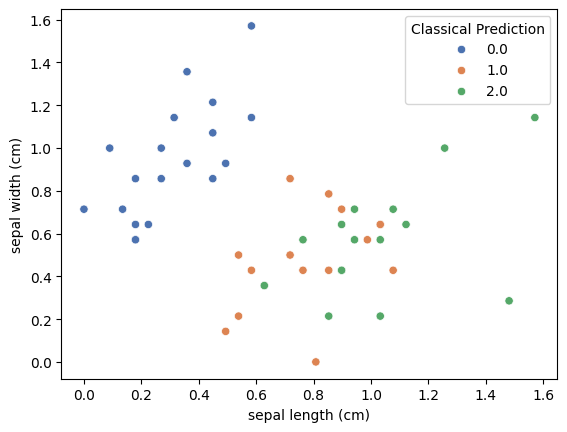

In [77]:
sns.scatterplot(data=test_df, x=test_df.iloc[:,0], y=test_df.iloc[:,1], hue='Classical Prediction', palette="deep")

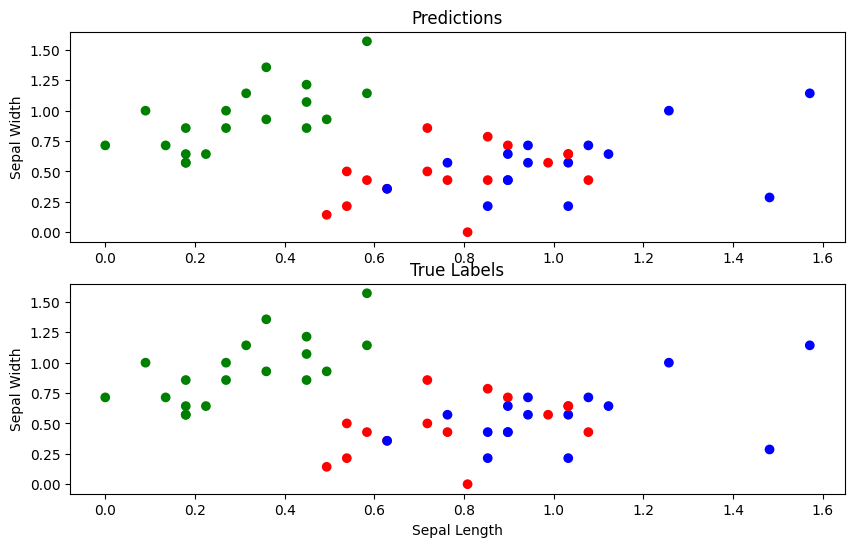

In [78]:
fig, ax = plt.subplots(2, figsize=(10, 6))

colours = {0 : 'green', 1 : 'red', 2 : 'blue'}

ax[0].scatter(test_df.iloc[:,0],test_df.iloc[:,1], c = test_df.iloc[:,6].map(colours))
ax[0].set_title("Predictions")
#ax[0].set_xlabel("Sepal Length")
ax[0].set_ylabel("Sepal Width")

ax[1].scatter(test_df.iloc[:,0],test_df.iloc[:,1], c = test_df.iloc[:,7].map(colours))
ax[1].set_title("True Labels")
ax[1].set_xlabel("Sepal Length")
ax[1].set_ylabel("Sepal Width")

colours = {'0' : 'green', '1' : 'red', '2' : 'blue'}

plt.show()

In [ ]:
train_df.head()

## Quantum classifier

In [ ]:
classes = np.zeros(len(test_df))
expectations = np.zeros(len(test_df))
for i in range(len(test_df)):
  classes[i] = classify_tri(get_expectation(test_df.iloc[i][0:4],U_conv_6, theta))
  expectations[i] = get_expectation(test_df.iloc[i][0:4],U_conv_6, theta)

In [ ]:
classes[:10], expectations[:10], test_df.iloc[:10]['label']

In [152]:
data = np.array(train_df.iloc[:,:4].values)

In [ ]:
better_predictions = np.zeros(len(test_df))
expectations = np.zeros(len(test_df))
for i in range(len(test_df)):
  better_predictions[i] = classify_tri(get_expectation(test_df.iloc[i][0:4],U_conv_6, theta))
  expectations[i] = get_expectation(test_df.iloc[i][0:4],U_conv_6, theta)


## Classical Explainer

In [79]:
origional_explainer = lime.lime_tabular.LimeTabularExplainer(test_df.iloc[:,:4].values, feature_names=test_df.columns[:4], class_names=iris.target_names, discretize_continuous=True)

In [94]:
i = np.random.randint(0, test_df.shape[0])
print(test_df.iloc[:,:4].values[49])
origional_exp = origional_explainer.explain_instance(test_df.iloc[:,:4].values[49], rf.predict_proba, num_features=4, top_labels=3)

[1.25663706 0.99959766 1.35780699 1.57079633]


c:\Users\migue\miniconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [92]:
origional_exp.show_in_notebook(show_table=True, show_all=True)

## Q explainer

In [157]:
###Assign probabilities
def create_probabilities(input_X):

  if input_X.ndim == 1:
    input_X = np.reshape(input_X,(1,input_X.shape[0]))
  expectation_values = np.zeros(input_X.shape[0])
  for i in range(input_X.shape[0]):
    expectation_values[i] = get_expectation(input_X[i],U_conv_6, theta)
    probabilities = np.zeros((input_X.shape[0],3))
  for i in range(input_X.shape[0]):
    e = expectation_values[i]
    magnitude = 2*(np.abs(e-1)+np.abs(e-2)+np.abs(e-0))
    p_0 = (np.abs(e-1)+np.abs(e-2))/magnitude
    p_1 = (np.abs(e-0)+np.abs(e-2))/magnitude
    p_2 = (np.abs(e-1)+np.abs(e-0))/magnitude

    if (p_0 < p_1) & (p_0 < p_2):
      p_0 = 0
    if (p_1 < p_0) &( p_1 < p_2):
      p_1 = 0
    if (p_2 < p_0) & (p_2 < p_1):
      p_2 = 0

    probabilities[i,:] = np.array([p_0, p_1, p_2])
    probabilities[i,:] = probabilities[i,:]/(probabilities[i,:].sum())
    
  return probabilities

In [158]:
from lime.lime_tabular import LimeTabularExplainer

q_explainer = lime.lime_tabular.LimeTabularExplainer(train_df.iloc[:,:4].values, feature_names=train_df.columns[:4], class_names=iris.target_names, discretize_continuous=True)
q_exp = q_explainer.explain_instance(test_df.iloc[:,:4].values[49], create_probabilities, num_features=2, top_labels=3)

In [ ]:
q_exp.show_in_notebook(show_table=True, show_all=True)

# LIME using a VQC as the explained classifier.


Sample around a certain point (Done)

Calculate the distance between the sampled instances and the instance being explained (Done)

For these synthetically generated instances, make predictions using the original global model (Done)

Fit a simple linear model on this data set

This linear model is weighted based on the similarity index calculated in step 2. 

This is to ensure that the errors on the instances most closest to the original instance are valued more than others.







Current method is to modify LIME code to take the expectation of a classifing model.

## Lime with Binary data

In [160]:
#Takes a 4d vector and returns a series of points in the local area.
#I assume the point x is in the domain [0,pi/2]
def sample_about_point(x,R,N):
  #N is the number of points over the axis that is considered

  #Consider a hypersquare with the point at the center of side length R
  start_w = max(0,x[0] - R)
  end_w = min(x[0] + R, np.pi/2)
  start_x = max(0,x[1] - R)
  end_x = min(x[1] + R, np.pi/2)
  start_y = max(0,x[2] - R)
  end_y = min(x[2] + R, np.pi/2)
  start_z = max(0,x[3] - R)
  end_z = min(x[3] + R, np.pi/2)

  w = np.linspace(start_w,end_w,N, endpoint = True)
  x = np.linspace(start_x,end_x,N, endpoint = True)
  y = np.linspace(start_y,end_y,N, endpoint = True)
  z = np.linspace(start_z,end_z,N, endpoint = True)

  ww, xx, yy, zz = np.meshgrid(w,x,y,z)

  w_flat = ww.reshape(N**4)
  x_flat = xx.reshape(N**4)
  y_flat = yy.reshape(N**4)
  z_flat = zz.reshape(N**4)
  fs = np.array([w_flat,x_flat, y_flat, z_flat]).reshape(N**4,4)

  feature_space = pd.DataFrame([w_flat,x_flat, y_flat, z_flat]).T
  feature_space.columns = features[0:4]
  return feature_space


In [ ]:
x = np.array([1,1,0.5,1]) 
R = 0.1
N = 20
sample_data = sample_about_point(x,R,N)

In [ ]:
def lime_get_bi_fs_pred(sample_data):
  bi_fs_exp = np.zeros(len(sample_data))
  bi_fs_pred = np.zeros(len(sample_data))

  for i in range(N**4):
     bi_fs_exp[i] = get_expectation_bi(sample_data.iloc[i][0:4],U_conv_6, theta)
     bi_fs_pred[i] = classify_bi(bi_fs_exp[i])
     

  return  bi_fs_pred,  bi_fs_exp  

  
lime_bi_pred, lime_bi_exp = lime_get_bi_fs_pred(sample_data)

sample_data.insert(4,'Expectation Values', lime_bi_exp)
sample_data.insert(5,'Quantum Prediction', lime_bi_pred)

In [ ]:
sample_data = sample_data.sample(100)

In [ ]:
sample_df = pd.DataFrame(sample_data)
sns.pairplot(sample_data, palette = 'magma', hue = 'Expectation Values')

In [ ]:
#find the value of the projector pi_x(z)
def pi_x(x,z):
  #x is the point of interest
  #z is an array of local sample points, not that dataframes must be converted 
  #to numpy arrays.
  #returns projective weights
  projected_weights = np.zeros(z.shape[0])
  for i in range(z.shape[0]):
    projected_weights[i] = np.exp(-(np.linalg.norm(x-z[i])))

  #Using exponential decay kernel
  return projected_weights

To choose the best model I will create a family of models of differeent types with varying parameter numbers. I will use LASSO regression with K features, where K varies between 1 and 4.

In [ ]:
sample_df.iloc[:,0:4]